# 1 - Importando bibliotecas e carregando dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#Lendo os dados

hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep = ';')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

hypotheses.info()
print(hypotheses.head())

orders.info()
print(orders.head())

visits.info()
print(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
                                          Hypothesis  Reach  Impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   Confidence  Effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1     

#### Sobre os dados

Alterações necessárias em 'hypotheses':
- Padronizar os nomes das colunas transformando para letras minúsculas

Alterações em 'orders':
- Transformar o tipo de dados na coluna date para datetime

Alterações em 'visits':
- Transformar o tipo de dados na coluna date para datetime

# 2 - Preparação dos dados

In [3]:
#Alterações no conjunto de dados 'hypotheses'

hypotheses.columns = hypotheses.columns.str.lower()

#Checando o resultado
print(hypotheses.head())

                                          hypothesis  reach  impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   confidence  effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  


In [4]:
#Alterações no conjunto de dados 'orders'

orders['date'] = pd.to_datetime(orders['date'])

#Checando o resultado
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [5]:
#Alterações no conjunto de dados 'visits'

visits['date'] = pd.to_datetime(visits['date'])

#Checando o resultado
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [6]:
#Procurando por valores duplicados

#Linhas duplicadas
orders_duplicated = orders.duplicated().sum()
print(orders_duplicated) #Não há

#Id de pedidos duplicados
transaction_id_duplicated = orders['transactionId'].duplicated().sum()
print(transaction_id_duplicated) #Não há

#Id de usuários duplicados
visitor_id_duplicated_sum = orders['visitorId'].duplicated().sum()
print(visitor_id_duplicated_sum) #Há 166

0
0
166


In [7]:
#Usuários duplicados em 'orders'

#Usuários que fazem parte dos dois grupos

#Filtrando por usuários de cada grupo
visitors_group_a = set(orders.loc[orders['group'] == 'A', 'visitorId'])
visitors_group_b = set(orders.loc[orders['group'] == 'B', 'visitorId'])

#Checando se há usuários que fazem parte dos dois grupos
duplicated_visitors = visitors_group_a.intersection(visitors_group_b)

print(f"Usuários presentes nos dois grupos: {len(duplicated_visitors)}")



#Removendo usuários que fazem parte dos dois grupos em 'orders'
orders = orders[~orders['visitorId'].isin(duplicated_visitors)]

Usuários presentes nos dois grupos: 58


#### Sobre a preparação dos dados

Identifiquei 58 usuários que estão presentes tanto no grupo A quanto no grupo B do teste. Como esse número é baixo em relação ao volume total de dados em orders, optei por excluir todos os registros desses 58 usuários para evitar viés na análise dos resultados do teste A/B.

# 3 - Análise de Dados

In [8]:
#Priorizando hipóteses

#Framework ICE
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']
print(hypotheses[['ICE', 'hypothesis']].sort_values('ICE', ascending = False))


#Framework RICE
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']
print(hypotheses[['RICE', 'hypothesis']].sort_values('RICE', ascending = False))

         ICE                                         hypothesis
8  16.200000  Launch a promotion that gives users discounts ...
0  13.333333  Add two new channels for attracting traffic. T...
7  11.200000  Add a subscription form to all the main pages....
6   8.000000  Show banners with current offers and sales on ...
2   7.000000  Add product recommendation blocks to the store...
1   2.000000  Launch your own delivery service. This will sh...
5   1.333333  Add a customer review page. This will increase...
3   1.125000  Change the category structure. This will incre...
4   1.000000  Change the background color on the main page. ...
    RICE                                         hypothesis
7  112.0  Add a subscription form to all the main pages....
2   56.0  Add product recommendation blocks to the store...
0   40.0  Add two new channels for attracting traffic. T...
6   40.0  Show banners with current offers and sales on ...
8   16.2  Launch a promotion that gives users discounts ...


#### Sobre a priorização das hipóteses

No framework ICE, o impacto e a confiança em cada hipótese têm mais peso, enquanto o esforço para execução penaliza hipóteses mais caras ou complexas. O alcance (reach) dos usuários não é considerado.

No framework RICE, o alcance (reach) é incluído na fórmula, além do impacto e da confiança, dando prioridade a hipóteses que atingem mais usuários.

Ou seja, a principal diferença entre ICE e RICE é que o reach mede quantos usuários serão afetados, influenciando a priorização das hipóteses.

         date group  revenue
0  2019-08-01     A   2266.6
1  2019-08-01     B    967.2
2  2019-08-02     A   1468.3
3  2019-08-02     B   2568.1
4  2019-08-03     A   1815.2
..        ...   ...      ...
57 2019-08-29     B   1681.2
58 2019-08-30     A   1228.9
59 2019-08-30     B   3286.8
60 2019-08-31     A    848.3
61 2019-08-31     B   1787.7

[62 rows x 3 columns]


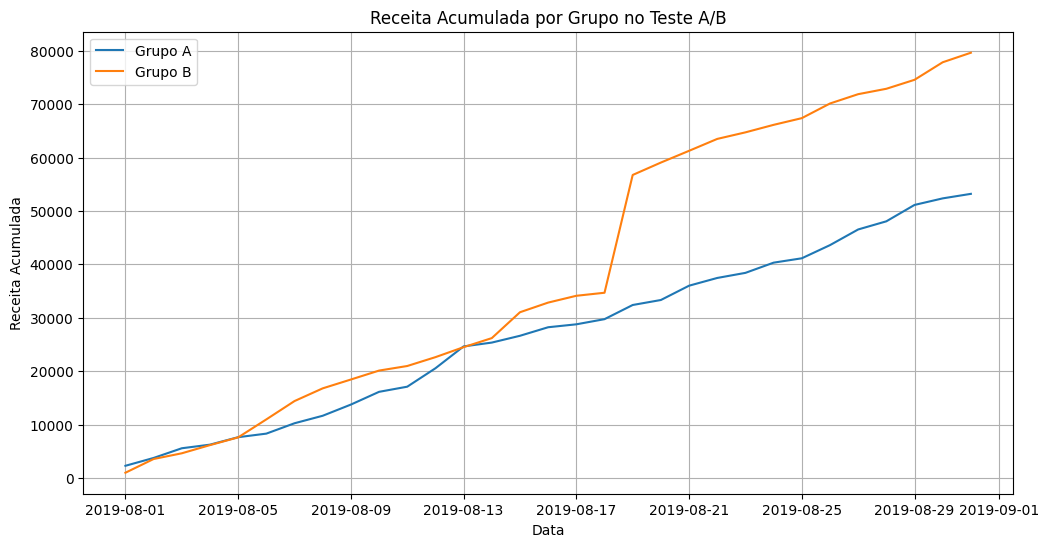

In [9]:
# 1 - Receita acumulada por grupo


#Calculando a receita acumulada por grupo
revenue_group = orders.groupby(['date', 'group'])['revenue'].sum().reset_index()
print(revenue_group)

#Transformando e pivot
revenue_pivot = revenue_group.pivot(index='date', columns='group', values='revenue').fillna(0)

#Receita acumulada
cumulative_revenue = revenue_pivot.cumsum()

#Gráfico
plt.figure(figsize=(12,6))
plt.plot(cumulative_revenue.index, cumulative_revenue['A'], label='Grupo A')
plt.plot(cumulative_revenue.index, cumulative_revenue['B'], label='Grupo B')
plt.title('Receita Acumulada por Grupo no Teste A/B')
plt.xlabel('Data')
plt.ylabel('Receita Acumulada')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusões - Questão 1

Com base no gráfico, é possível observar que a receita acumulada pelo grupo B é maior do que a receita acumulada pelo grupo A, principalmente após a data de 17/08/2019, quando a receita do grupo B apresentou um crescimento constante.

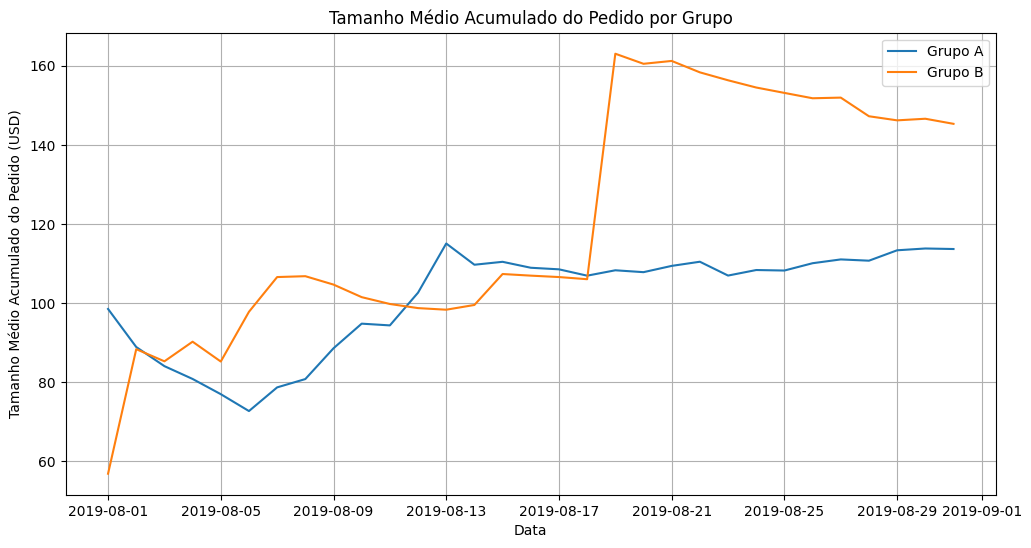

In [10]:
#2 - Tamanho médio acumulado do pedido por grupo

#Número de pedidos diariamente por grupo
orders_group = orders.groupby(['date', 'group'])['transactionId'].count().reset_index()



#Transformando em pivot
orders_pivot = orders_group.pivot(index='date', columns='group', values='transactionId').fillna(0)

#Cálculo acumulado
cumulative_orders = orders_pivot.cumsum()

#Tamanho médio acumulado do pedido
average_order_cumulative = cumulative_revenue / cumulative_orders


#Gráfico
plt.figure(figsize=(12,6))
plt.plot(average_order_cumulative.index, average_order_cumulative['A'], label='Grupo A')
plt.plot(average_order_cumulative.index, average_order_cumulative['B'], label='Grupo B')
plt.title('Tamanho Médio Acumulado do Pedido por Grupo')
plt.xlabel('Data')
plt.ylabel('Tamanho Médio Acumulado do Pedido (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusões - Questão 2

Em termos de tamanho médio acumulado por pedido, o grupo B apresentou desempenho superior ao grupo A. Observa-se no gráfico que, a partir de 17/08/2019, o tamanho médio acumulado por pedido do grupo B teve um aumento significativo em relação ao grupo A.

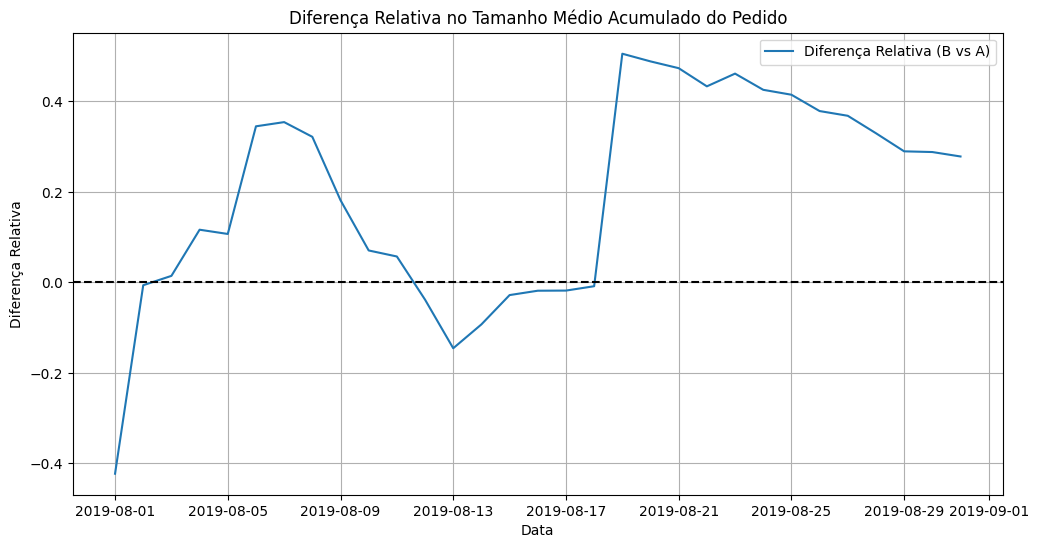

In [11]:
#3 - Diferença relativa no tamanho médio acumulado do pedido para o grupo B em comparação com o grupo A

#Diferença relativa
diff_relative = (average_order_cumulative['B'] - average_order_cumulative['A']) / average_order_cumulative['A']


#Gráfico
plt.figure(figsize=(12,6))
plt.plot(diff_relative.index, diff_relative, label='Diferença Relativa (B vs A)')
plt.title('Diferença Relativa no Tamanho Médio Acumulado do Pedido')
plt.xlabel('Data')
plt.ylabel('Diferença Relativa')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusões - Questão 3


De acordo com o gráfico, o grupo B tem um tamanho médio acumulado por pedido maior em relação ao grupo A, principalmente após a data de 17/08/2019.

        date group  transactionId  visits  conversion_rate
0 2019-08-01     A             23     719         0.031989
1 2019-08-01     B             17     713         0.023843
2 2019-08-02     A             19     619         0.030695
3 2019-08-02     B             23     581         0.039587
4 2019-08-03     A             24     507         0.047337
5 2019-08-03     B             14     509         0.027505
6 2019-08-04     A             11     717         0.015342
7 2019-08-04     B             14     770         0.018182
8 2019-08-05     A             22     756         0.029101
9 2019-08-05     B             21     707         0.029703


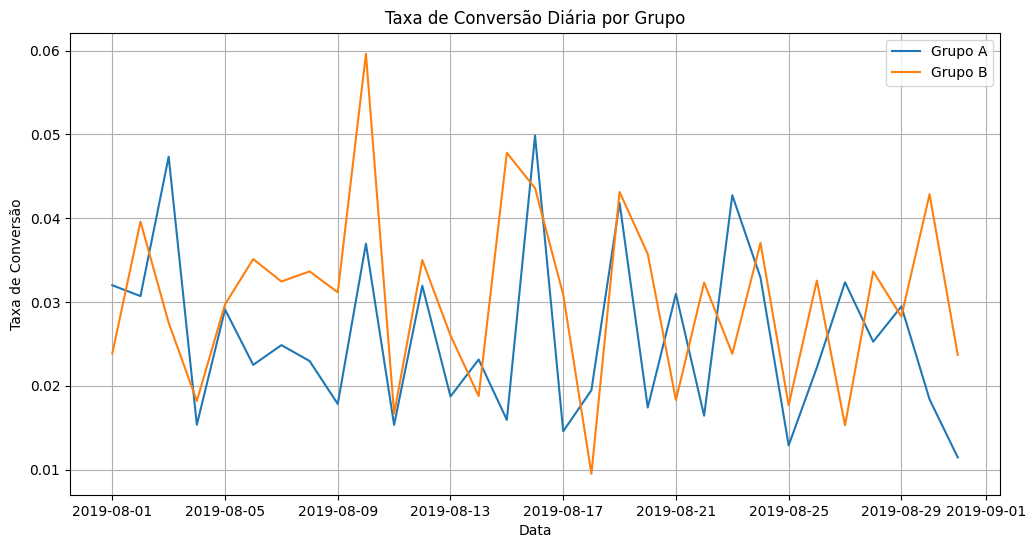

In [12]:


#4 - Taxa de conversão de cada grupo e proporção de pedidos para o número de visitas para cada dia


#Agrupando pedidos por data e grupo
daily_orders = orders.groupby(['date', 'group'])['transactionId'].nunique().reset_index()

#Calculando o número de pedidos por dia por cada grupo
daily_visits = visits.groupby(['date', 'group'])['visits'].sum().reset_index()

#Juntando visitas e pedidos
conversion_data = daily_orders.merge(daily_visits, on=['date','group'])

#Calculando taxa de conversão
conversion_data['conversion_rate'] = conversion_data['transactionId'] / conversion_data['visits']
print(conversion_data.head(10))


#Gráfico
plt.figure(figsize=(12,6))
plt.plot(conversion_data[conversion_data['group'] == 'A']['date'], 
         conversion_data[conversion_data['group'] == 'A']['conversion_rate'], 
         label='Grupo A')
plt.plot(conversion_data[conversion_data['group'] == 'B']['date'], 
         conversion_data[conversion_data['group'] == 'B']['conversion_rate'], 
         label='Grupo B')
plt.title('Taxa de Conversão Diária por Grupo')
plt.xlabel('Data')
plt.ylabel('Taxa de Conversão')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusões - Questão 4

A taxa de conversão diária dos grupos A e B é aparentemente parecida, apresentando apenas algumas variações, como em 09/08/2019, quando o grupo B teve uma taxa de conversão acentuadamente maior em relação ao grupo A.

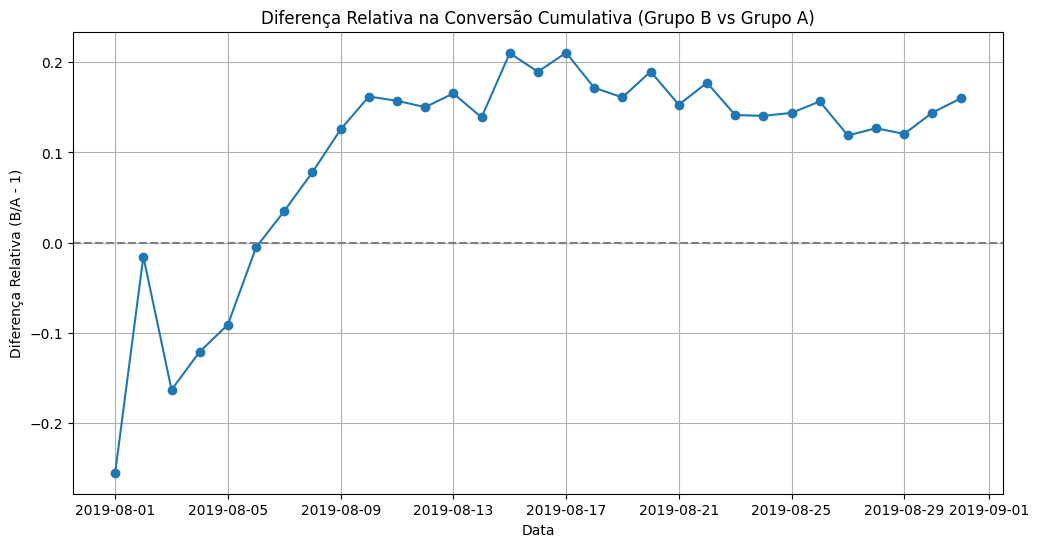

In [13]:
#5- Gráfico da diferença relativa na conversão cumulativa para o grupo B em comparação com o grupo A

#Conversão cumulativa
conversion_data['cum_orders'] = conversion_data.groupby('group')['transactionId'].cumsum()
conversion_data['cum_visits'] = conversion_data.groupby('group')['visits'].cumsum()
conversion_data['cum_conversion'] = conversion_data['cum_orders'] / conversion_data['cum_visits']

#Pivotando
pivot_cum = conversion_data.pivot(index='date', columns='group', values='cum_conversion')

#Diferença relativa do grupo B em relação ao grupo A
pivot_cum['rel_diff_BA'] = (pivot_cum['B'] / pivot_cum['A']) - 1

#Gráfico
plt.figure(figsize=(12,6))
plt.plot(pivot_cum.index, pivot_cum['rel_diff_BA'], marker='o')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Diferença Relativa na Conversão Cumulativa (Grupo B vs Grupo A)')
plt.xlabel('Data')
plt.ylabel('Diferença Relativa (B/A - 1)')
plt.grid(True)
plt.show()

#### Conclusões - Questão 5

A conversão cumulativa do grupo B supera a do grupo A a partir de 05/08/2019.

In [14]:
#6 - Percentis 95 e 99 para o número de pedidos por usuário


#Número de pedidos por usuário
orders_per_user = orders.groupby('visitorId')['transactionId'].nunique()

#Calculando percentis 95 e 99
perc_95 = np.percentile(orders_per_user, 95)
perc_99 = np.percentile(orders_per_user, 99)

print(f"Percentil 95: {perc_95}")
print(f"Percentil 99: {perc_99}")

#Definindo ponto de anomalia
print(f"Acima de {perc_99} pedidos por usuário podemos considerar como anomalia.")

Percentil 95: 1.0
Percentil 99: 2.0
Acima de 2.0 pedidos por usuário podemos considerar como anomalia.


#### Conclusões - Questão 6

95% dos usuários fazem até 1 pedido e 99% dos usuários fazem até 2 pedidos. O ponto de anomalia definido foi 2, ou seja, acima de 2 pedidos por usuário podemos considerar uma anomalia.

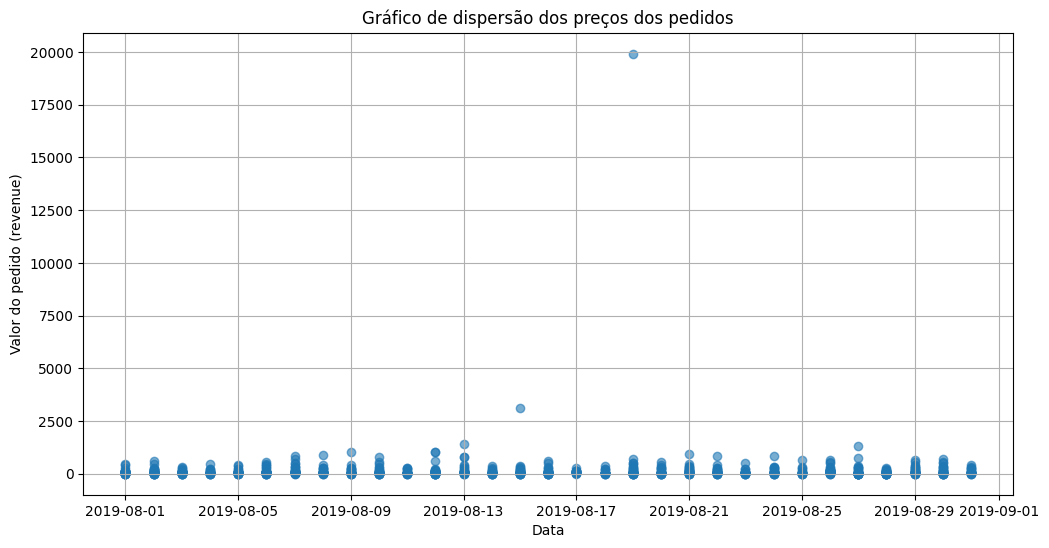

In [15]:
#7 - Gráfico de dispersão dos preços dos pedidos

#Gráfico
plt.figure(figsize=(12,6))
plt.scatter(orders['date'], orders['revenue'], alpha=0.6)
plt.title("Gráfico de dispersão dos preços dos pedidos")
plt.xlabel("Data")
plt.ylabel("Valor do pedido (revenue)")
plt.grid(True)
plt.show()

#### Conclusões - Questão 7

A grande maioria dos pedidos possui valores próximos, sem ultrapassar 1.000 dólares. No gráfico, é possível identificar dois pedidos com valores significativamente mais altos: o primeiro ocorreu entre 13/08/2019 e 17/08/2019, e o segundo entre 17/08/2019 e 21/08/2019.

In [16]:
#8 - Percentis 95 e 99 dos preços dos pedidos


#Pegando apenas os valores de revenue
order_values = orders['revenue']

#Calculando percentis 95 e 99
perc_95 = np.percentile(order_values, 95)
perc_99 = np.percentile(order_values, 99)

print(f"Percentil 95 dos preços dos pedidos: {perc_95}")
print(f"Percentil 99 dos preços dos pedidos: {perc_99}")

#Definindo ponto de anomalia
print(f"Pedidos com valor acima de {perc_99} podem ser considerados anomalias.")

Percentil 95 dos preços dos pedidos: 414.275
Percentil 99 dos preços dos pedidos: 830.3
Pedidos com valor acima de 830.3 podem ser considerados anomalias.


#### Conclusões - Questão 8

95% dos pedidos tem valor até 414 dólares e 99% dos pedidos tem valor de até 830 dólares. O ponto de anomalia é 830, ou seja, pedidos acima de 830 dólares são considerados anomalias.

In [17]:
#9 - Encontre a significância estatística da diferença na conversão entre os grupos usando os dados brutos

#Usuário com 0 = não comprou, 1 = comprou
orders['converted'] = 1

#Agrupando por visitante e grupo
visitors_conversion = orders.groupby(['visitorId','group'])['converted'].max().reset_index()


group_a = visitors_conversion[visitors_conversion['group'] == 'A']['converted']
group_b = visitors_conversion[visitors_conversion['group'] == 'B']['converted']


#Teste Estatístico

#Hipótese nula (H0): não há diferença na taxa de conversão entre os grupos A e B.
#Hipótese alternativa (H1): existe diferença na taxa de conversão entre os grupos.

#Teste não paramétrico
stat, p_value = stats.mannwhitneyu(group_a, group_b, alternative='two-sided')

print(f"Estatística U: {stat}")
print(f"Valor-p: {p_value:.3f}")

Estatística U: 117480.0
Valor-p: 1.000


#### Conclusões - Questão 9

A conversão dos grupos A e B é praticamente a mesma, não há evidências de que um grupo esteja performando melhor que o outro. Portanto, com base nesses dados brutos, não podemos afirmar que o teste A/B apresenta diferença relevante na taxa de conversão.

In [18]:
#10 - Encontre a significância estatística da diferença no tamanho médio do pedido entre os grupos usando os dados brutos


#Pedidos do grupo A e B
orders_a = orders[orders['group'] == 'A']['revenue']
orders_b = orders[orders['group'] == 'B']['revenue']



#Teste estatístico

#Hipótese nula: Não há diferença no tamanho médio do pedido entre os grupos A e B.
#Hipótese alternativa: Há diferença no tamanho médio do pedido entre os grupos A e B.

#Teste não paramétrico para comparar distribuições
stat, p_value = stats.mannwhitneyu(orders_a, orders_b, alternative='two-sided')

print(f"Estatística U: {stat}")
print(f"Valor-p: {p_value:.3f}")

mean_a = orders_a.mean()
mean_b = orders_b.mean()

print(f"Média do tamanho do pedido - Grupo A: {mean_a:.2f}")
print(f"Média do tamanho do pedido - Grupo B: {mean_b:.2f}")


Estatística U: 129041.5
Valor-p: 0.862
Média do tamanho do pedido - Grupo A: 113.70
Média do tamanho do pedido - Grupo B: 145.35


#### Conclusões - Questão 10

A média do tamanho do pedido do grupo B é maior em relação ao grupo A, mas o teste estatístico demonstrou que não há diferença estatisticamente significativa entre os grupos A e B no tamanho médio do pedido.

In [19]:
#11 - Encontre a significância estatística da diferença na conversão entre os grupos usando os dados filtrados


#Limite de preço (95 percentil)
price_95 = np.percentile(orders['revenue'], 95)

#Limite de número de pedidos por usuário (95 percentil)
orders_per_user = orders.groupby('visitorId')['transactionId'].nunique()
limit_orders = np.percentile(orders_per_user, 95)

#Criando tabela filtrada
valid_users = orders_per_user[orders_per_user <= limit_orders].index
clean_orders = orders[
    (orders['visitorId'].isin(valid_users)) &
    (orders['revenue'] <= price_95)
]


#Compradores únicos em cada grupo
buyers = clean_orders.groupby('group')['visitorId'].nunique().reset_index()
buyers.columns = ['group', 'buyers']

#Total de visitantes em cada grupo
total_visitors = visits.groupby('group')['visits'].sum().reset_index()

#Juntando as informações
conversion = buyers.merge(total_visitors, on='group')
conversion['conversion_rate'] = conversion['buyers'] / conversion['visits']

print(conversion)




#Teste estatístico

#Hipótese nula: Não há diferença na taxa de conversão entre os grupos A e B.
#Hipótese alternativa: Existe diferença na taxa de conversão entre os grupos A e B.

visitors_dict = total_visitors.set_index('group')['visits'].to_dict()
buyers_dict = buyers.set_index('group')['buyers'].to_dict()

group_a = np.array([1] * buyers_dict['A'] + [0] * (visitors_dict['A'] - buyers_dict['A']))
group_b = np.array([1] * buyers_dict['B'] + [0] * (visitors_dict['B'] - buyers_dict['B']))

u_stat, p_value = stats.mannwhitneyu(group_a, group_b, alternative='two-sided')

print(f"Estatística U: {u_stat}")
print(f"Valor-p: {p_value}")

if p_value < 0.05:
    print("Diferença estatisticamente significativa entre as conversões dos grupos A e B.")
else:
    print("Não há diferença estatisticamente significativa entre as conversões dos grupos A e B.")

  group  buyers  visits  conversion_rate
0     A     406   18736         0.021670
1     B     481   18916         0.025428
Estatística U: 176539028.0
Valor-p: 0.016200908573143418
Diferença estatisticamente significativa entre as conversões dos grupos A e B.


#### Conclusões - Questão 11

Após filtrar outliers, o teste estatístico demonstrou que há uma diferença estatisticamente significativa entre os grupos, onde o grupo B teve uma taxa de conversão maior do que o grupo A.

In [20]:
#12 - Encontre a significância estatística da diferença no tamanho médio do pedido entre os grupos usando os dados filtrados


#Selecionar o revenue de cada grupo
group_a_revenue = clean_orders[clean_orders['group'] == 'A']['revenue']
group_b_revenue = clean_orders[clean_orders['group'] == 'B']['revenue']

#Teste estatístico

#Hipótese nula: Não há diferença no tamanho médio do pedido entre os grupos A e B nos dados filtrados.
#Hipótese alternativa: Existe diferença no tamanho médio do pedido entre os grupos A e B nos dados filtrados.


u_stat, p_value = stats.mannwhitneyu(group_a_revenue, group_b_revenue, alternative='two-sided')

print(f"Estatística U: {u_stat}")
print(f"Valor-p: {p_value}")

if p_value < 0.05:
    print("Diferença estatisticamente significativa no tamanho médio do pedido entre os grupos A e B (dados filtrados).")
else:
    print("Não há diferença estatisticamente significativa no tamanho médio do pedido entre os grupos A e B (dados filtrados).")

Estatística U: 98749.0
Valor-p: 0.7711877309994826
Não há diferença estatisticamente significativa no tamanho médio do pedido entre os grupos A e B (dados filtrados).


#### Conclusões - Questão 12


Mesmo após filtrar outliers, o teste estatístico demonstrou que não há diferença estatisticamente significativa entre os grupos A e B em relação ao tamanho médio do pedido.

# 4 - Conclusão 


De acordo com os testes estatísticos, ao filtrar outliers o grupo B teve uma performance melhor em relação ao grupo A na conversão. Ou seja, os usuários do grupo B convertem melhor do que os usuários do grupo A.
E em relação ao tamanho médio do pedido, não houve diferença estatisticamente significativa entre os grupos. 

Com esses resultados, podemos considerar o grupo B o líder e o time de marketing deve considerar acatar a mudança testada na variante B.